In [ ]:
import kagglehub
imsparsh_musicnet_dataset_path = kagglehub.dataset_download('imsparsh/musicnet-dataset')
print('Data source import complete.')

In [2]:
!pip install mido
!pip install pygame
!pip install music21

     |████████████████████████████████| 52 kB 487 kB/s eta 0:00:011
     |████████████████████████████████| 11.8 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 19.2 MB 343 kB/s  eta 0:00:01
  Created wheel for music21: filename=music21-6.7.1-py3-none-any.whl size=21941692 sha256=37254fecf4e300627876d8d682dbf13e8f8ade7813f0b0b6c41ea611ed4b493c
  Stored in directory: /root/.cache/pip/wheels/72/44/61/90e4e65262ca1b4d9f707527b540729ce3f64e00fc6b38d54c
Successfully built music21


In [5]:
import pandas as pd
import numpy as np
from mido import MidiFile
import pygame
import IPython
import matplotlib.pyplot as plt
import librosa.display
import keras.layers as L
import keras.models as M
import keras
from keras.layers import SimpleRNN,LSTM,GRU
from sklearn.model_selection import train_test_split
from IPython import *
from music21 import *
import os
import tensorflow as tf

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [7]:
data=pd.read_csv('../input/musicnet-dataset/musicnet_metadata.csv')

In [ ]:
mid=MidiFile('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven/2313_qt15_1.mid',clip=True)
mid.tracks

[<midi track 'L.v.Beethoven 1mov - String Quartet No.15 in A minor Op.132\x00' 325 messages>,
 <midi track 'Violin1' 3277 messages>,
 <midi track 'Violin2' 2898 messages>,
 <midi track 'Viola' 2916 messages>,
 <midi track 'Cello' 2491 messages>,
 <midi track 'Violin1 Sub' 40 messages>]

In [ ]:
for i in mid.tracks[1] :
    print(i)

<meta message track_name name='Violin1' time=0>
control_change channel=0 control=0 value=0 time=0
program_change channel=0 program=40 time=0
control_change channel=0 control=7 value=100 time=0
control_change channel=0 control=10 value=20 time=0
control_change channel=0 control=91 value=127 time=0
<meta message key_signature key='Am' time=0>
control_change channel=0 control=11 value=127 time=0
note_on channel=0 note=69 velocity=1 time=0
note_off channel=0 note=69 velocity=100 time=188
control_change channel=0 control=11 value=90 time=2860
note_on channel=0 note=63 velocity=40 time=24
control_change channel=0 control=11 value=100 time=24
control_change channel=0 control=11 value=114 time=24
control_change channel=0 control=11 value=127 time=24
note_off channel=0 note=63 velocity=100 time=692
note_on channel=0 note=64 velocity=45 time=4
note_off channel=0 note=64 velocity=100 time=764
control_change channel=0 control=11 value=70 time=4
note_on channel=0 note=72 velocity=90 time=0
control_

note_off channel=0 note=80 velocity=100 time=324
note_on channel=0 note=82 velocity=90 time=60
note_off channel=0 note=82 velocity=100 time=380
note_on channel=0 note=81 velocity=82 time=4
note_off channel=0 note=81 velocity=100 time=192
note_on channel=0 note=79 velocity=78 time=0
note_off channel=0 note=79 velocity=100 time=192
note_on channel=0 note=77 velocity=74 time=0
note_off channel=0 note=77 velocity=100 time=380
note_on channel=0 note=79 velocity=65 time=4
note_off channel=0 note=79 velocity=100 time=192
note_on channel=0 note=81 velocity=61 time=0
note_off channel=0 note=81 velocity=100 time=188
note_on channel=0 note=79 velocity=60 time=4
note_off channel=0 note=79 velocity=100 time=572
note_on channel=0 note=76 velocity=60 time=4
note_off channel=0 note=76 velocity=100 time=188
note_on channel=0 note=77 velocity=60 time=4
note_off channel=0 note=77 velocity=100 time=572
note_on channel=0 note=71 velocity=60 time=4
note_off channel=0 note=71 velocity=100 time=188
note_on ch

In [ ]:
note_on=[]
n=50
for m in range(n):
    mid=MidiFile('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven/'+os.listdir('../input/musicnet-dataset/musicnet_midis/musicnet_midis/Beethoven')[m],clip=True)
    for j in range(len(mid.tracks)):
        for i in mid.tracks[j] :
            if str(type(i))!="<class 'mido.midifiles.meta.MetaMessage'>" :
                x=str(i).split(' ')
                if x[0]=='note_on':
                    note_on.append(int(x[2].split('=')[1]))

In [11]:
import time
from IPython.display import clear_output
def live_plot_make(x,range_=20,pause_time=0.01,skip_a_do=1):
    for i in range(0,len(x)-range_,skip_a_do):
        plt.figure(figsize=(18,8))
        x_plot=x[i:i+range_]
        y_plot=[i for i in range(range_)]
        fig=plt.plot(y_plot,x_plot,marker='D')
        plt.ylim([min(x),max(x)])
        time.sleep(pause_time)
        clear_output(wait=True)
        plt.show()


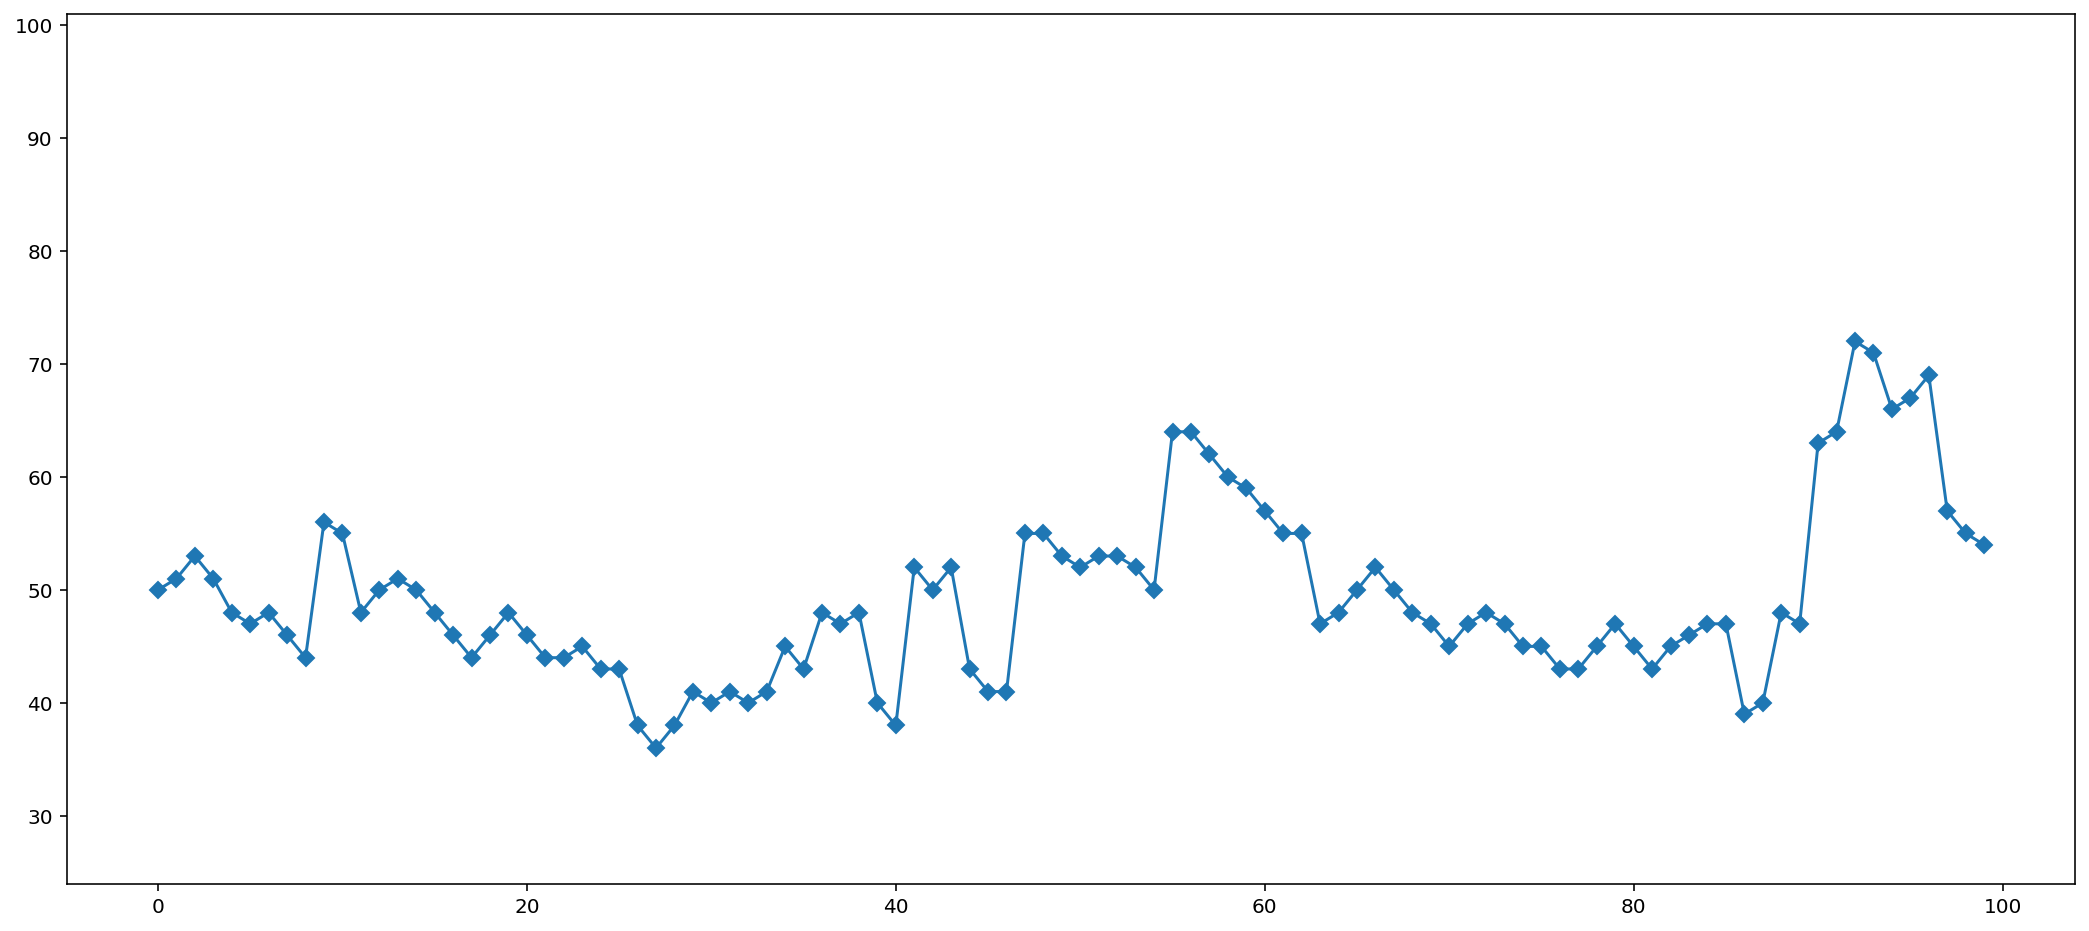

In [12]:
live_plot_make(note_on,range_=100,pause_time=0.02,skip_a_do=1000)

In [ ]:
'''We are gonna take a frame of 10 notes at a time since we have 1437 notes takin 10 notes at a time will give us
        about 1427 training samples . Lets try :)'''
training_data=[]
labels=[]
for i in range(20,len(note_on)):
    training_data.append(note_on[i-20:i])
    labels.append(note_on[i])

In [15]:
print('Training data is :',training_data[0],' The label for it is :',labels[0])

Training data is : [82, 82, 80, 77, 74, 75, 70, 70, 68, 65, 62, 63, 55, 82, 82, 80, 77, 74, 75, 70]  The label for it is : 70


In [ ]:
different_labels=set(labels)
print('The different type of labels that we can have and might need to predict are : ',len(different_labels))

The different type of labels that we can have and might need to predict are :  77


In [17]:
# Function to build the model
def build_model():
    model=M.Sequential()
    model.add(LSTM(128,input_shape=(10,1)))
    model.add(L.Dense(1,'relu'))
    model.compile(loss='MSE',optimizer='adam')
    return model

In [18]:
def build_model_softmax():
    model=M.Sequential()
    model.add(LSTM(128,input_shape=(10,1),return_sequences=True))
    model.add(LSTM(128))
    model.add(L.Flatten())
    model.add(L.Dense(40,'relu'))
    model.add(L.Dense(40,'softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam')
    return model

In [19]:
def build_model_lstm2():
    model=M.Sequential()
    model.add(LSTM(200,input_shape=(10,1),unroll=True,return_sequences=True))
    model.add(L.Dropout(0.4))
    model.add(LSTM(100))
    model.add(L.Dense(100,'relu'))
    model.add(L.Dropout(0.2))
    model.add(L.Dense(1,'relu'))
    model.compile(loss='MSE',optimizer='adam')
    return model

In [ ]:
def build_model_softmax():
    model=M.Sequential()
    model.add(LSTM(200,input_shape=(10,1),unroll=True,return_sequences=True))
    model.add(L.Dropout(0.4))
    model.add(LSTM(100))
    model.add(L.Dense(100,'relu'))
    model.add(L.Dropout(0.2))
    model.add(L.Dense(1,'relu'))
    model.compile(loss='MSE',optimizer='adam')
    return model

In [20]:
with strategy.scope():
    model=build_model_lstm2()

In [21]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0)

In [22]:
training_data=np.array(training_data)
training_data=training_data.reshape((training_data.shape[0],training_data.shape[1],1))
labels=np.array(labels)

In [23]:
# Let's make training and validation data
X_train, X_test, y_train, y_test = train_test_split(training_data, labels, test_size=0.05, random_state=42)

In [24]:
X_train.shape

(199270, 20, 1)

In [25]:
model.fit(X_train,y_train,epochs=200,batch_size=32 * strategy.num_replicas_in_sync,
          validation_data=(X_test,y_test),callbacks=[early_stop])

Epoch 1/200
779/779 [==============================] - 24s 19ms/step - loss: 854.8030 - val_loss: 63.4426
Epoch 2/200
779/779 [==============================] - 10s 13ms/step - loss: 89.6804 - val_loss: 62.1386
Epoch 3/200
779/779 [==============================] - 10s 13ms/step - loss: 85.4492 - val_loss: 58.1689
Epoch 4/200
779/779 [==============================] - 10s 13ms/step - loss: 81.8900 - val_loss: 54.3920
Epoch 5/200
779/779 [==============================] - 10s 13ms/step - loss: 78.9988 - val_loss: 52.4248
Epoch 6/200
779/779 [==============================] - 11s 14ms/step - loss: 76.7108 - val_loss: 51.2285
Epoch 7/200
779/779 [==============================] - 10s 13ms/step - loss: 74.8469 - val_loss: 52.2121
Epoch 8/200
779/779 [==============================] - 11s 14ms/step - loss: 74.4269 - val_loss: 48.9698
Epoch 9/200
779/779 [==============================] - 11s 14ms/step - loss: 73.0301 - val_loss: 50.3679
Epoch 10/200
779/779 [==============================] 

779/779 [==============================] - 10s 13ms/step - loss: 40.6893 - val_loss: 35.0088
Epoch 79/200
779/779 [==============================] - 11s 14ms/step - loss: 40.8404 - val_loss: 33.7918
Epoch 80/200
779/779 [==============================] - 10s 13ms/step - loss: 40.4356 - val_loss: 34.2646
Epoch 81/200
779/779 [==============================] - 10s 13ms/step - loss: 40.0841 - val_loss: 33.8519
Epoch 82/200
779/779 [==============================] - 10s 13ms/step - loss: 39.9743 - val_loss: 33.7049
Epoch 83/200
779/779 [==============================] - 10s 13ms/step - loss: 39.3046 - val_loss: 34.3231
Epoch 84/200
779/779 [==============================] - 10s 13ms/step - loss: 39.3673 - val_loss: 34.0564
Epoch 85/200
779/779 [==============================] - 11s 14ms/step - loss: 39.2161 - val_loss: 34.4713
Epoch 86/200
779/779 [==============================] - 10s 13ms/step - loss: 38.7455 - val_loss: 34.0783
Epoch 87/200
779/779 [==============================] - 10s

Epoch 155/200
779/779 [==============================] - 10s 13ms/step - loss: 28.8081 - val_loss: 31.6361
Epoch 156/200
779/779 [==============================] - 10s 13ms/step - loss: 28.4851 - val_loss: 31.1629
Epoch 157/200
779/779 [==============================] - 10s 13ms/step - loss: 28.4210 - val_loss: 31.3115
Epoch 158/200
779/779 [==============================] - 10s 13ms/step - loss: 28.3690 - val_loss: 31.0423
Epoch 159/200
779/779 [==============================] - 10s 13ms/step - loss: 28.1569 - val_loss: 31.5680
Epoch 160/200
779/779 [==============================] - 10s 13ms/step - loss: 27.8098 - val_loss: 31.0858
Epoch 161/200
779/779 [==============================] - 10s 13ms/step - loss: 27.8098 - val_loss: 32.0810
Epoch 162/200
779/779 [==============================] - 10s 13ms/step - loss: 28.2069 - val_loss: 31.5239
Epoch 163/200
779/779 [==============================] - 10s 13ms/step - loss: 27.3540 - val_loss: 32.4309
Epoch 164/200
779/779 [==============

In [26]:
# Saving the model
model.save('Auto_Song_Maker.h5')

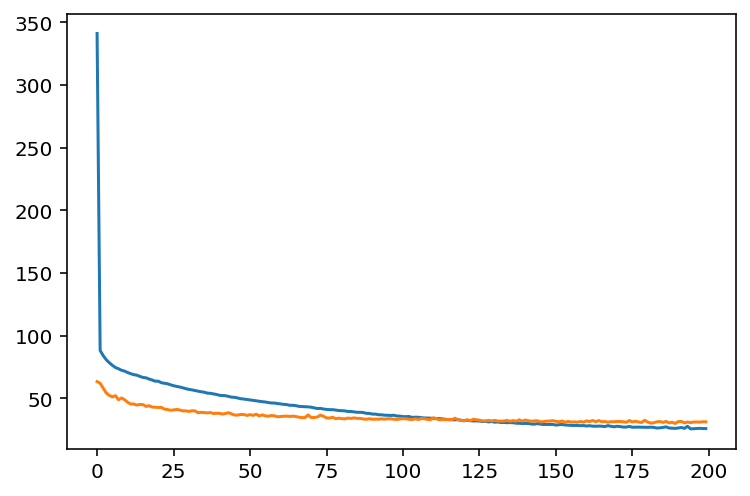

In [27]:
history=model.history.history
plt.plot([i for i in range(len(history['loss']))],history['loss'])
plt.plot([i for i in range(len(history['val_loss']))],history['val_loss'])

In [28]:
training_data[0].reshape(1,20,1)

array([[[82],
        [82],
        [80],
        [77],
        [74],
        [75],
        [70],
        [70],
        [68],
        [65],
        [62],
        [63],
        [55],
        [82],
        [82],
        [80],
        [77],
        [74],
        [75],
        [70]]])

In [29]:
model.predict(training_data[0].reshape(1,20,1))[0][0]

70.89203

In [54]:
###### Let's do some random predictions now
n=200
starter_notes=training_data[0]
x=training_data[0].reshape(1,20,1)
tune=list(training_data[0].reshape(-1,))
for i in range(n) :
    pred=int(model.predict(x)[0][0])
    if round(pred)==round(tune[-1]):
        p=np.random.choice(['a','b','c'])
        if p=='a':
            pred=65
        elif p=='b':
            pred=60
        else:
            pred=70
    tune.append(pred)
    x=tune[-10:]
    x=np.array(x)
    x=x.reshape(1,10,1)
    

In [55]:
tune=list(np.array(tune).astype('float32'))

In [56]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for patterns in tune:
    pattern=str(patterns)
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [57]:
output_notes

[<music21.chord.Chord B-5 C>,
 <music21.chord.Chord B-5 C>,
 <music21.chord.Chord G#5 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord D5 C>,
 <music21.chord.Chord E-5 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord G#4 C>,
 <music21.chord.Chord F4 C>,
 <music21.chord.Chord D4 C>,
 <music21.chord.Chord E-4 C>,
 <music21.chord.Chord G3 C>,
 <music21.chord.Chord B-5 C>,
 <music21.chord.Chord B-5 C>,
 <music21.chord.Chord G#5 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord D5 C>,
 <music21.chord.Chord E-5 C>,
 <music21.chord.Chord B-4 C>,
 <music21.chord.Chord C4 C>,
 <music21.chord.Chord G4 C>,
 <music21.chord.Chord B4 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord B5 C>,
 <music21.chord.Chord C6 C>,
 <music21.chord.Chord B5 C>,
 <music21.chord.Chord B-5 C>,
 <music21.chord.Chord G5 C>,
 <music21.chord.Chord C4 C>,
 <music21.chord.Chord F4 C>,
 <music21.chord.Chord F5 C>,
 <music21.chord.Chord C6 C>,
 <music21.chord.Chord E6 C>,


In [58]:
midi_stream = stream.Stream(output_notes)


In [59]:
midi_stream.write('midi','test_output.mid')

'test_output.mid'

In [ ]:
%apt install fluidsynth #Pip does not work for some reason. Only apt works
%pip install midi2audio
%pip install pyFluidSynth


!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/font.sf2

from midi2audio import FluidSynth
from google.colab import output
from IPython.display import display, Javascript, HTML, Audio

In [ ]:
FluidSynth("/content/font.sf2").midi_to_audio('test_output.mid','output2.wav')
# set the src and play
Audio("output2.wav")

In [61]:
IPython.display.Audio('./test_output.wav')